<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Build A (Basic) Random Forest from Scratch

_Authors: Kiefer Katovich (SF)_

---

> **Note**: this is intended to be a group work lab or a codealong with the instructor.


## What is a Random Forest?

---

Random Forests are some of the most widespread classifiers used. They are relatively simple to use because they require very few parameters to set and they perform well. As we have seen, Decision Trees are very powerful machine learning models.

Decision Trees have some critical limitations. In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets. Bagging helps mitigate this problem by exposing different trees to different sub-samples of the whole training set.

Random forests are a further way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance. This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.

### Feature bagging

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. This process is sometimes called feature bagging. 

The reason for doing this is due to correlation of trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be selected in many of the bagging base trees, causing them to become correlated. By selecting a random subset of the features at each split, we avoid this correlation between base trees, strengthening the overall model.

**For a problem with p features, it is typical to use:**
- `p^(1/2)` (rounded down) features in each split for a classification problem.
- `p/3` (rounded down) with a minimum node size of 5 as the default for a regression problem.

## Lab Instructions

---

**A Random Forest classifier is built satisfying these conditions:**
1. Multiple internal decision tree classifiers will be built as the base models.
- For each base model, the data will be resampled with replacement (bootstrapping).
- Each decision tree will be fit on one of the bootstrapped samples of the original data.
- To predict, each internal base model will be passed the new data and make their predictions. The final output will be a vote across the base models for the class.

**Your custom random forest classifier must:**
1. Accept hyperparameters `max_features`, `n_estimators`, and `max_depth`.
2. Implement a `fit` method.
3. Implement a `predict` method.
4. Implement a `score` method.
5. Satisfy the conditions for random forest classifiers listed above!
6. **You will not be implementing feature bagging in this lab, for the sake of simplicity!**

**Test your random forest classifier on the (pre-cleaned) Titanic dataset and compare the performance to a single decision tree classifier!**

> *Note: you are allowed to use the `DecisionTreeClassifier` class in sklearn for the internal base estimators. This lab is about building the random forest ensemble estimator, not building a decision tree class!*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
titanic = pd.read_csv('../data/titanic.csv')

# Map Sex labels to binary
titanic['Sex'] = titanic.Sex.map({'male':0, 'female':1})

# Remove rows with missing values
titanic.dropna(inplace=True)

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.5500,C103,S


In [4]:
titanic.shape

(183, 12)

In [5]:
# 'S': Southampton
# 'C': Cherbourg
# 'Q': Queenstown
titanic['Embarked'].value_counts()

S    116
C     65
Q      2
Name: Embarked, dtype: int64

In [6]:
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')

# Remove 1st column because logic doesn't require it
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [7]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,0,1
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,PP 9549,16.7000,G6,S,0,1
11,12,1,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.5500,C103,S,0,1


In [8]:
feature_cols = titanic.columns.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Embarked'])

X =  titanic[feature_cols]
y = titanic.Survived

In [9]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,0,0
3,1,1,35.0,1,0,53.1000,0,1
6,1,0,54.0,0,0,51.8625,0,1
10,3,1,4.0,1,1,16.7000,0,1
11,1,1,58.0,0,0,26.5500,0,1


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=89)

### Use single Decision Tree Classifier to compare results

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [12]:
# List of max_depth values
max_depth_range = list(range(1, 10))

# List to store average RMSE scores for each value of max_depth
RMSE_scores = []

# Use LOOCV with each value of max_depth
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(clf, X_train, y_train, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

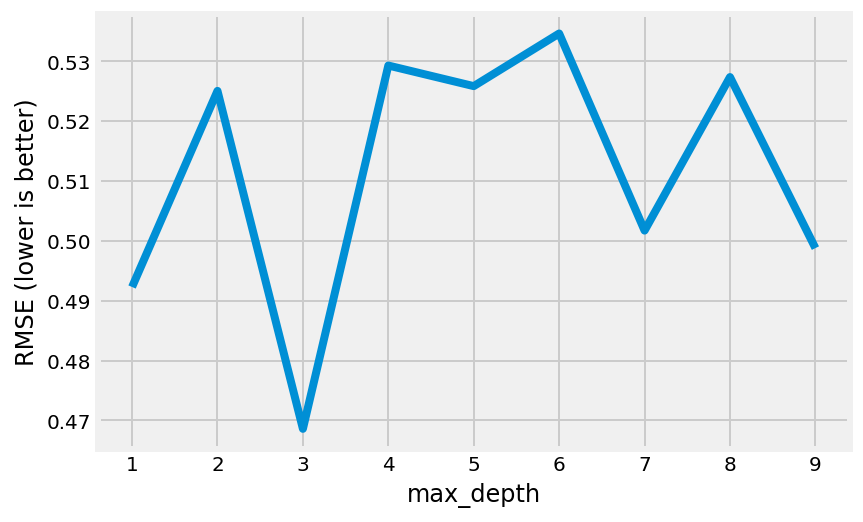

In [13]:
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [14]:
# max_depth=3 with RMSE of 0.469
sorted(zip(RMSE_scores, max_depth_range))[0]

(0.4685810391903451, 3)

In [15]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=1)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [16]:
# Fare, Age and Sex are only features being used in decision tree (see visualization below)
pd.DataFrame({'feature':feature_cols, 'importance':tree_clf.feature_importances_}).sort_values(by='importance')

,feature,importance
0,Pclass,0.000000
3,SibSp,0.000000
4,Parch,0.000000
6,Embarked_Q,0.000000
7,Embarked_S,0.000000
5,Fare,0.029049
2,Age,0.407463
1,Sex,0.563488


In [17]:
print("Test Accuracy: {}%".format(round(tree_clf.score(X_test, y_test) * 100, 2)))

y_pred = tree_clf.predict(X_test)
print("Decision Tree Classifier report: \n\n", classification_report(y_test, y_pred))

Test Accuracy: 76.09%
Decision Tree Classifier report: 

               precision    recall  f1-score   support

           0       0.62      1.00      0.77        18
           1       1.00      0.61      0.76        28

    accuracy                           0.76        46
   macro avg       0.81      0.80      0.76        46
weighted avg       0.85      0.76      0.76        46



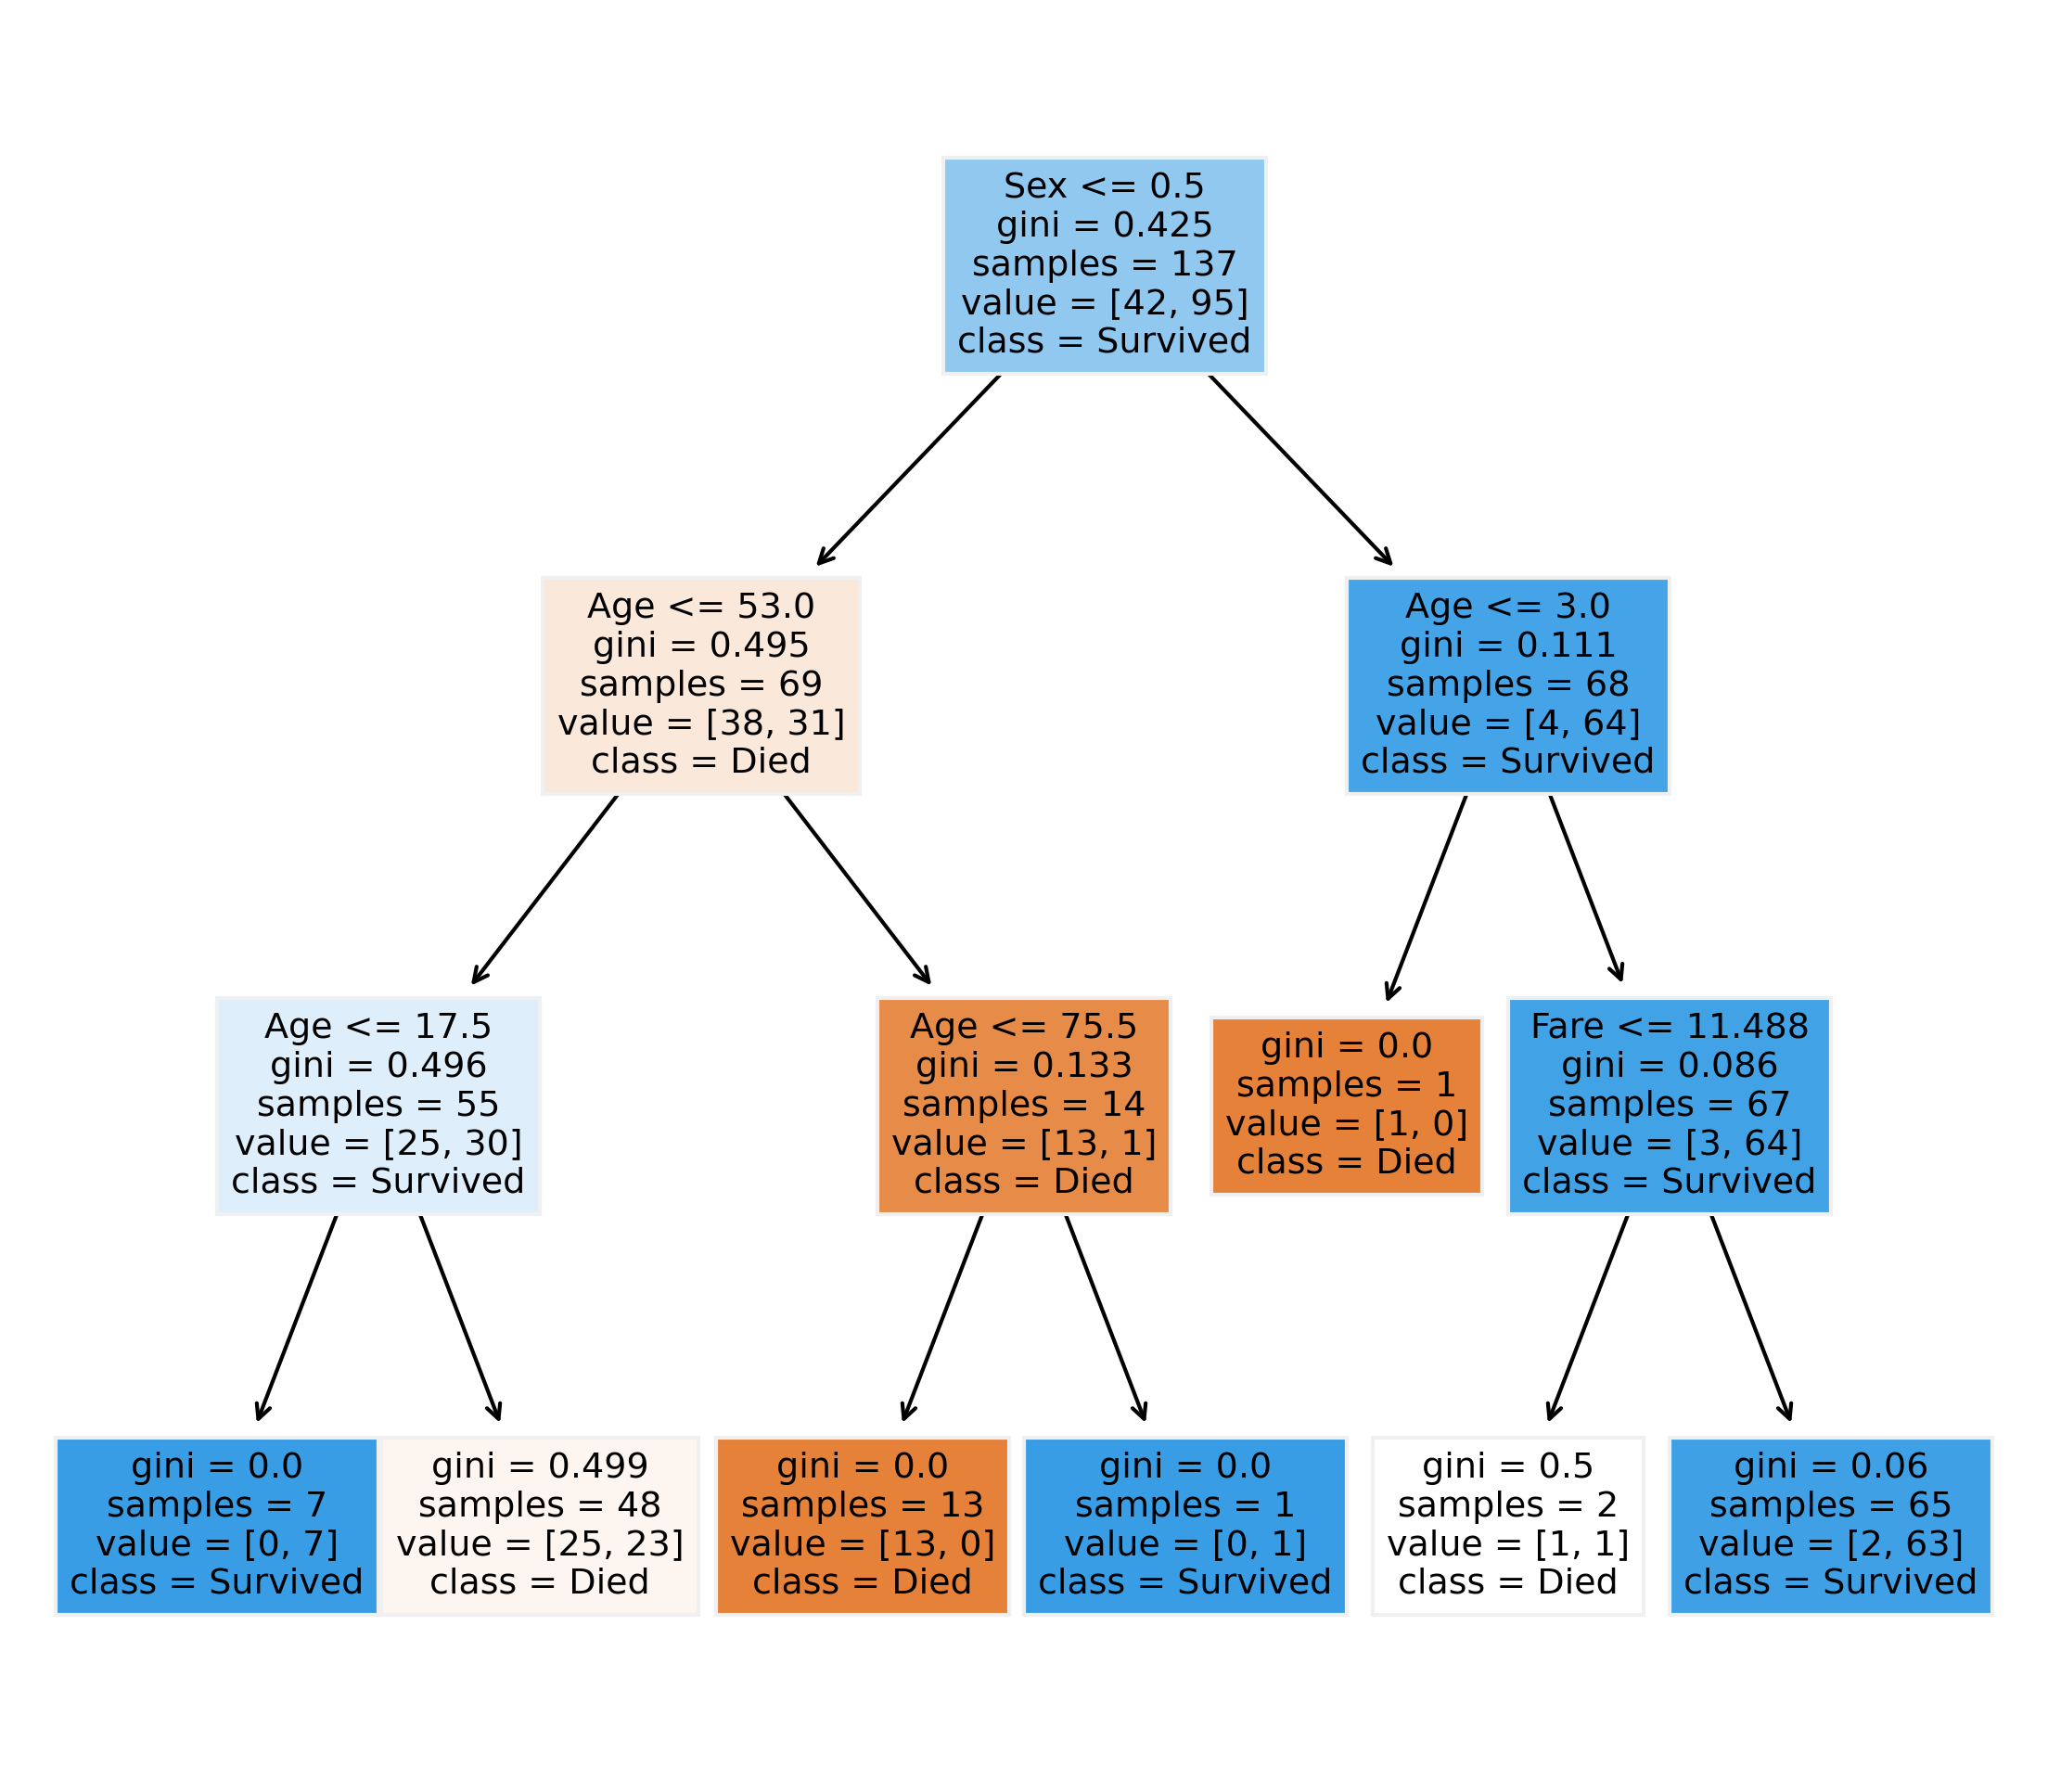

In [18]:
from sklearn import tree

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
tree.plot_tree(tree_clf, feature_names=feature_cols, class_names=['Died', 'Survived'], filled=True);

### Use RandomForestClassifier 

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Tune n_estimators for model
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators
RMSE_scores = []

# Use 5-fold cross-validation with each value of n_estimators (Warning: Slow!)
for estimator in estimator_range:
    rf_clf = RandomForestClassifier(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rf_clf, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    

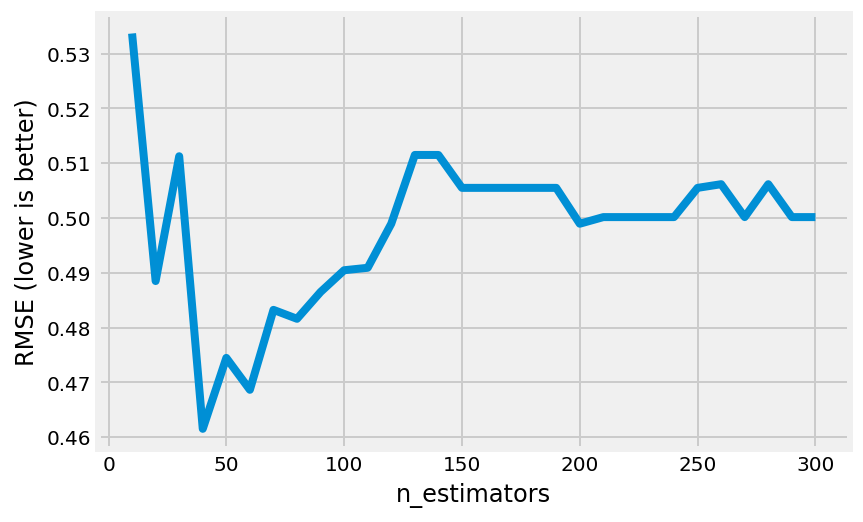

In [21]:
# Plot RMSE (y-axis) versus n_estimators (x-axis)
plt.plot(estimator_range, RMSE_scores);
plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

In [22]:
# Lowest RMSE 0.4615 with n_estimator=40
sorted(zip(RMSE_scores, estimator_range))[0]

(0.4615111959357764, 40)

In [23]:
# Tune max_features for the model

# List of values for max_features (1 – (col no.+ 1))
feature_range = list(range(1, len(feature_cols) + 1))

# List to store the average RMSE for each value of max_features
RMSE_scores = []

# 10-fold cross-validation with each value of max_features (Warning: Slow!)
for feature in feature_range:
    rf_clf = RandomForestClassifier(n_estimators=40, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rf_clf, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    

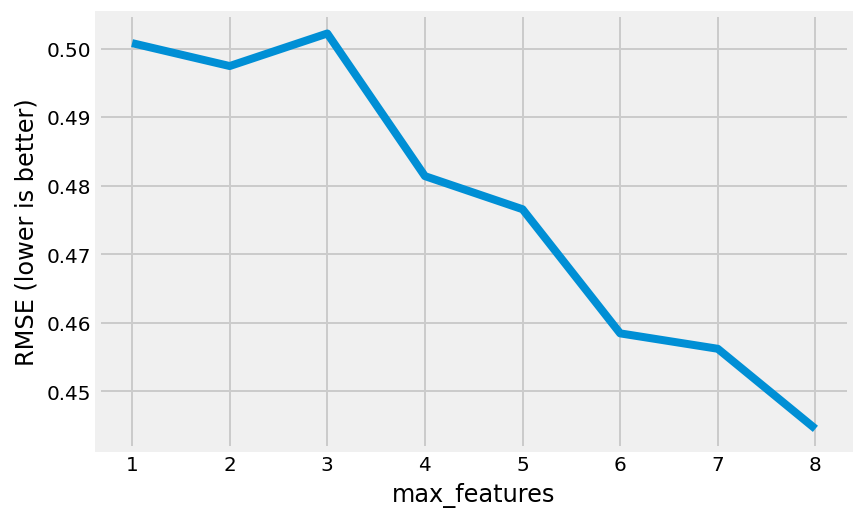

In [24]:
plt.plot(feature_range, RMSE_scores);
plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');

In [25]:
# RMSE decreased slightly to 0.4445 with max_features=8
sorted(zip(RMSE_scores, feature_range))[0]

(0.44454278059962044, 8)

In [26]:
# Train new model with tuned parameters
clf = RandomForestClassifier(n_estimators=40, max_features=8, oob_score=True, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=8, n_estimators=40, oob_score=True,
                       random_state=1)

In [27]:
# The higher the value, the more important the feature, i.e. Age, Sex and Fare
# Where the passenger embarked has the least importance - would removing it improve model performance???
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
2,Age,0.398189
1,Sex,0.278673
5,Fare,0.233206
4,Parch,0.045185
3,SibSp,0.020376
0,Pclass,0.012627
7,Embarked_S,0.010955
6,Embarked_Q,0.000790


In [28]:
# Compute the out-of-bag R-squared score
print("OOB score:", (clf.oob_score_))

# Find the average RMSE
scores = cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

OOB score: 0.7226277372262774


0.44454278059962044

In [ ]:
# RMSE score improves slightly but OOB score worse than single Decision Tree

In [29]:
# Set up predictions variable to run other metrics
pred = clf.predict(X_test)

from sklearn.metrics import precision_score, accuracy_score
prec_score = precision_score(y_test, pred)
acc_score = accuracy_score(y_test, pred)

In [30]:
print("Accuracy score on test set:", round((acc_score * 100), 2))
print("Precision score on test set:", round((prec_score * 100), 2))

Accuracy score on test set: 76.09
Precision score on test set: 75.76


In [ ]:
# What other parameters can we tune?
# max_depth, min_samples_leaf

In [ ]:
# Use RandomizedSearchCV to tune all hyperparameters

In [33]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop=200, num=20)]

# Number of features to consider at every split
max_features = list(range(1, len(feature_cols) + 1))

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num=20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
for key, value in random_grid.items():
    print(key, ' : ', value)

n_estimators  :  [30, 38, 47, 56, 65, 74, 83, 92, 101, 110, 119, 128, 137, 146, 155, 164, 173, 182, 191, 200]
max_features  :  [1, 2, 3, 4, 5, 6, 7, 8]
max_depth  :  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]
min_samples_split  :  [2, 5, 10]
min_samples_leaf  :  [2, 4, 8, 10]
bootstrap  :  [True, False]


In [35]:
# Using 3-fold cross-validation, search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [36]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60, 65,
                                                      70, 75, 80, 85, 90, 95,
                                                      100, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7,
                                                         8],
                                        'min_samples_leaf': [2, 4, 8, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [30, 38, 47, 56, 65, 74,
                                                         83, 92, 101, 110, 119,
                                                         128, 137, 146, 155,
 

In [37]:
rf_random.best_params_

{'n_estimators': 155,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 8,
 'max_depth': 70,
 'bootstrap': True}

In [38]:
# New model with all tuned parameters
random_clf = RandomForestClassifier(n_estimators=155,
                                    max_depth=70,
                                    max_features=8, 
                                    min_samples_split=5, 
                                    min_samples_leaf=10, 
                                    oob_score=True, 
                                    random_state=1)

random_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, max_features=8, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=155, oob_score=True,
                       random_state=1)

In [39]:
# Compute the out-of-bag R-squared score
print("OOB score:", (random_clf.oob_score_))

# Find the average RMSE
scores = cross_val_score(random_clf, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

OOB score: 0.7591240875912408


0.4877762240496927

In [ ]:
# Model accuracy increased but RMSE got slightly worse

In [40]:
pd.DataFrame({'feature':feature_cols, 'importance':random_clf.feature_importances_}).sort_values(by='importance')

,feature,importance
0,Pclass,0.000000
6,Embarked_Q,0.000000
7,Embarked_S,0.005945
4,Parch,0.011872
3,SibSp,0.014678
5,Fare,0.076922
2,Age,0.280919
1,Sex,0.609663


In [ ]:
# Might improve model further by removing Embarked and PClass features - did class of cabin not matter in survival???

In [4]:
# This will be custom, basic version of a Random Forest class in the style of sklearn's models
class RandomForest(object):
    
    def __init__(self):
        pass
        
    def fit(self):
        pass
    
    def predict(self):
        pass
    
    def score(self):
        pass